In [12]:
from __future__ import division
import numpy as np
from numpy import exp
import t1t2shuffle as t1t2sh
import epg
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

import sys
print(sys.version)

2.7.13 |Continuum Analytics, Inc.| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [13]:
def numerical_gradient(myfun, myparams, e=1e-5):

    initial_params = myparams.copy()
    num_grad = np.zeros(initial_params.shape)
    perturb = np.zeros(initial_params.shape)
    
    for p in range(len(initial_params)):
        
        perturb[p] = e
        
        loss2 = myfun(myparams + perturb)
        loss1 = myfun(myparams - perturb)
        
        num_grad[p] = (loss2 - loss1) / (2 * e)
        
        perturb[p] = 0.

        return num_grad

In [14]:
def read_angles(fliptable):
    f = open(fliptable, 'r')
    angles = []
    for line in f.readlines():
        angles.append(float(line))
    f.close()
    return np.array(angles)

In [15]:
def FR_FSE(T1, T2, TR, TE, alpha_ex_rad, phi_ex_rad, alpha_ref_rad, phi_refoc_rad, alpha_fr_rad, alpha_phi_rad, M0=np.array([[0.],[0.],[1.]])):
    T = int(TR/TE)

    Mxy = np.zeros((T,1), dtype=np.complex)
    Mz = np.zeros((T,1), dtype=np.complex)

    P = np.copy(M0)
    
    # apply excitation pulse
    P = epg.rf(P, alpha_ex_rad, phi_ex_rad)

    Mxy[0] = P[0,0]
    Mz[0] = P[2,0]

    # apply refocusing pulses
    for i in xrange(ETL):

        alpha = alpha_ref_rad[i]
        phi = phi_refoc_rad[i]
        P = epg.FSE_TE(P, alpha, phi, TE, T1, T2)

        Mxy[i] = P[0,0]
        Mz[i] = P[2,0]

    # apply fr pulse
    P = epg.rf(P, alpha_fr_rad, alpha_phi_rad)

    # apply dead pulses
    for i in xrange(ETL, T):

        P = epg.FSE_TE(P, 0, 0, TE, T1, T2)

        Mxy[i] = P[0,0]
        Mz[i] = P[2,0]

    return Mxy, Mz

[ 0.53671067 +2.81423846e-38j]
[ 0.44047275+0.j]
[ 0.33013274 -2.81423846e-38j]


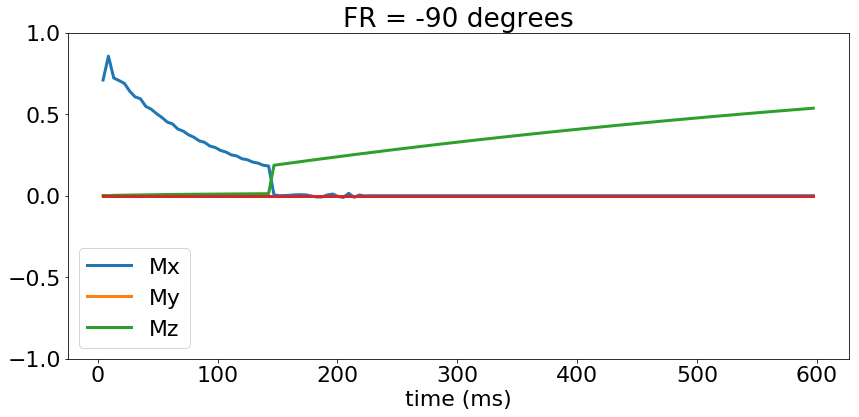

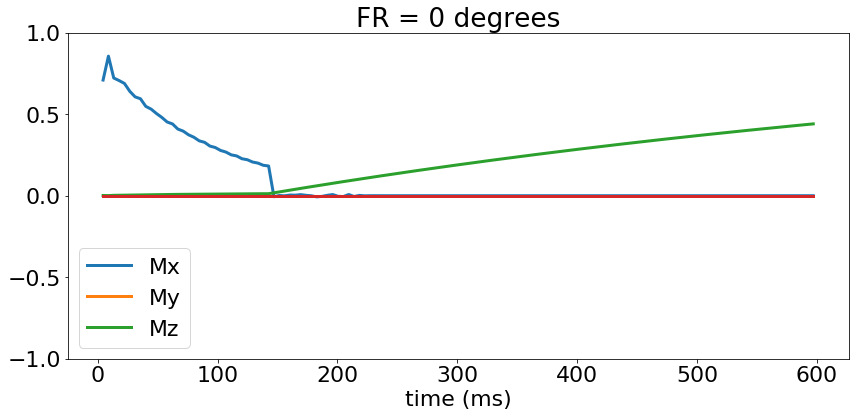

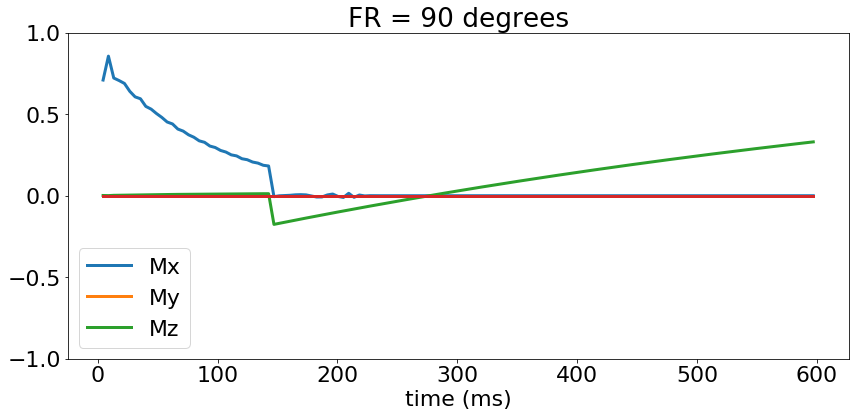

In [21]:
M0 = 1
T1 = 800
T2 = 80
TE = 4.456
B1 = 1

TR = 600

ETL = 32

# excitation pulse
alpha_e = 90
phi_e = 90

# refocusing pulses
angles_rad = 120 * np.ones((ETL,)) * np.pi/180
phase_rad = 0 * np.ones((ETL,))

alpha_fr_range = [-90, 0, 90] # range(-90,90, 10):
for alpha_fr in alpha_fr_range:
    # fast recovery pulse
    phi_fr = 90

    ### 
    alpha_e_rad = np.pi/180 * alpha_e
    phi_e_rad = np.pi/180 * phi_e

    alpha_fr_rad = np.pi/180 * alpha_fr
    phi_fr_rad = np.pi/180 * phi_fr

    M0 = np.array([[0.],[0.],[1.]])

    Mxy, Mz = FR_FSE(T1, T2, TR, TE, alpha_e_rad, phi_e_rad, angles_rad, phase_rad, alpha_fr_rad, phi_fr_rad, M0)

    echo_times = np.arange(TE, TR, TE)

    plt.figure(figsize=(14,6))
    plt.plot(echo_times, Mxy.real, echo_times, Mxy.imag, echo_times, Mz.real, echo_times, Mz.imag, linewidth=3);
    plt.xlabel('time (ms)')
    plt.ylim([-1,1])
    
    print(Mz[-1])
    
    plt.legend(('Mx', 'My', 'Mz'))
    plt.title('FR = {} degrees'.format(alpha_fr))

[ 0.37550373]
[ 0.34587041]
[ 0.28524972]


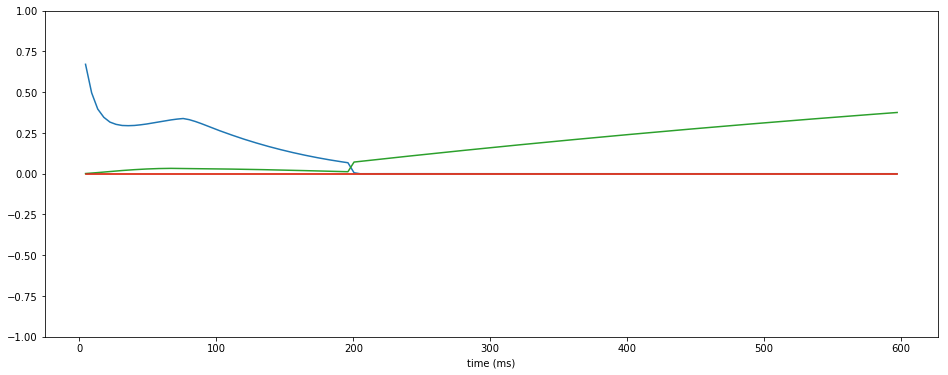

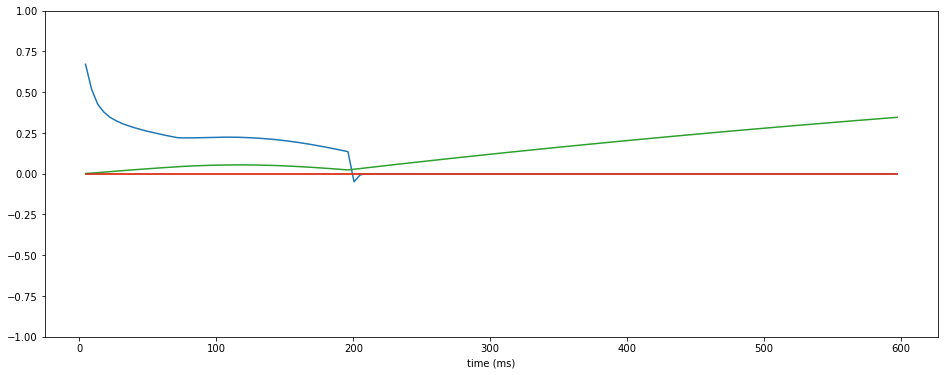

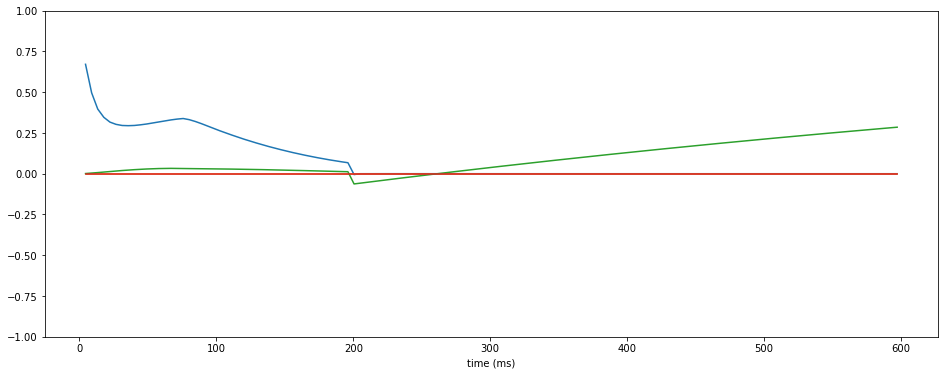

In [6]:
M0 = 1
T1 = 1000
T2 = 40
TE = 4.456
B1 = 1

TR = 600

ETL = 44

# excitation pulse
alpha_e = 90
phi_e = 90

# refocusing pulses
phase_rad = 0 * np.ones((ETL,))

angles_rad_0 = np.pi/180 * read_angles('/home/jtamir/t2shuffling-data/2018-03-27_varFR_brain_volunteer/27Mar2018_Ex4592_Ser7/flipangles.txt.327090110')
angles_rad_m = np.pi/180 * read_angles('/home/jtamir/t2shuffling-data/2018-03-27_varFR_brain_volunteer/27Mar2018_Ex4592_Ser8/flipangles.txt.327090741')
angles_rad_p = np.pi/180 * read_angles('/home/jtamir/t2shuffling-data/2018-03-27_varFR_brain_volunteer/27Mar2018_Ex4592_Ser9/flipangles.txt.327091409')

angles_rads = [angles_rad_0, angles_rad_m, angles_rad_p]
alpha_fr_range = [-90, 0, 90]

for i, alpha_fr in enumerate(alpha_fr_range):
    # fast recovery pulse
    phi_fr = 90
    angles_rad = angles_rads[i]

    alpha_e_rad = np.pi/180 * alpha_e
    phi_e_rad = np.pi/180 * phi_e

    alpha_fr_rad = np.pi/180 * alpha_fr
    phi_fr_rad = np.pi/180 * phi_fr

    M0 = np.array([[0.],[0.],[1.]])

    Mxy, Mz = FR_FSE(T1, T2, TR, TE, alpha_e_rad, phi_e_rad, angles_rad, phase_rad, alpha_fr_rad, phi_fr_rad, M0)

    echo_times = np.arange(TE, TR, TE)

    plt.figure(figsize=(16,6))
    plt.plot(echo_times, Mxy.real, echo_times, Mxy.imag, echo_times, Mz.real, echo_times, Mz.imag);
    plt.xlabel('time (ms)')
    plt.ylim([-1,1])
    
    print(Mz[-1].real)